# Pharmaceutical-Sales-prediction-using-facebook prophet

In [2]:
# import necessary libraries
import pandas as pd
import numpy as np
import dvc.api
import seaborn as sns
import matplotlib.pyplot as plt
import logging
import mlflow
# To ignore any warnings
import warnings                        
warnings.filterwarnings("ignore")
import os
import dvc.api
import logging

In [2]:
import logging

logging.basicConfig(
    #level=logging.DEBUG,
    format="{asctime} {levelname:<8} {mesDSVBGTFXX age}",
    style='{',
    filename='../log/prophet.log',
    filemode='w'
)

In [3]:
path = ['data/store.csv', 'data/train.csv', 'data/test.csv']
version = ['store_v1', 'train_v1', 'test_v1']

In [4]:
repo = '/home/michael/Pharmaceutical-Sales-prediction-across-multiple-stores'

data_url = dvc.api.get_url(
    path = path[0],
    repo = repo,
    rev=version[0]
    )
data_url2 = dvc.api.get_url(
    path = path[1],
    repo = repo,
    rev=version[1]
    )
data_url3 = dvc.api.get_url(
    path = path[2],
    repo = repo,
    rev=version[2]
    )

try:
    df_store = pd.read_csv(data_url)
except Exception as e: 
    logging.critical('This is a critical level msg!: ', exc_info=True)
    
try: 
    df_train = pd.read_csv(data_url2)
except Exception as e:   
    logging.critical('This is a critical level msg!: ', exc_info=True)
    
try:
    df_test = pd.read_csv(data_url3)
except Exception as e:
    logging.critical('This is a critical level msg!: ', exc_info=True)
    


In [5]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [7]:
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


### Data 

In [11]:
#data extraction
try:
    df_train['Date'] = pd.to_datetime(df_train['Date'])
    df_train['Year'] = df_train['Date'].dt.year
    df_train['Month'] = df_train['Date'].dt.month
    df_train['Day'] = df_train['Date'].dt.day
    df_train['WeekOfYear'] = df_train['Date'].dt.weekofyear
except Exception as e:
    logging.error('This is a critical level msg!: ', exc_info=True)

In [13]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7,31,31


Training df has no missing values.

In [14]:
#fill missing values in CompetitionDistance with median value
df_store['CompetitionDistance'].fillna(df_store['CompetitionDistance'].median(), inplace = True)

In [15]:
#fill missing values with mode
df_store['CompetitionOpenSinceMonth'].fillna(df_store['CompetitionOpenSinceMonth'].mode, inplace = True)
df_store['CompetitionOpenSinceYear'].fillna(df_store['CompetitionOpenSinceYear'].mode, inplace = True)
df_store['Promo2SinceWeek'].fillna(df_store['Promo2SinceWeek'].mode, inplace = True)
df_store['Promo2SinceYear'].fillna(df_store['Promo2SinceYear'].mode, inplace = True)
df_store['PromoInterval'].fillna(df_store['PromoInterval'].mode, inplace = True)
df_store.isnull().values.any()

False

In [16]:
train_store = df_train.merge(df_store, on=["Store"],how="inner")

In [17]:
train_store.shape

(1017209, 22)

## Prophet
- Implements a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

In [19]:
def preprocess_(df):
    # remove closed stores and those with no sales
    df = df[(df["Open"] != 0) & (df['Sales'] != 0)]

    # sales for the store number 1 (StoreType C)
    sales = df[df.Store == 1].loc[:, ['Date', 'Sales']]

    # reverse to the order: from 2013 to 2015
    sales = sales.sort_index(ascending = False)

    # to datetime64
    sales['Date'] = pd.DatetimeIndex(sales['Date'])
    sales = sales.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
    # plot daily sales
    ax = sales.set_index('ds').plot(figsize = (12, 4), color = "red")
    ax.set_ylabel('Daily Number of Sales')
    ax.set_xlabel('Date')
    plt.show()
    return sales 

In [20]:
# modeling holidays
def modeling_holiday(df):
    # create holidays dataframe
    state_dates = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b') & (df.StateHoliday == 'c')].loc[:, 'Date'].values
    school_dates = df[df.SchoolHoliday == 1].loc[:, 'Date'].values

    state = pd.DataFrame({'holiday': 'state_holiday',
                          'ds': pd.to_datetime(state_dates)})
    school = pd.DataFrame({'holiday': 'school_holiday',
                          'ds': pd.to_datetime(school_dates)})

    holidays = pd.concat((state, school))
    return holidays

In [ ]:
from fbprophet import Prophet
import pickle
import datetime
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics


class Fb_prophet:
    def __init__(self,train,holidays):
        self.future_dates = None
        self.forecast = None
        
        self.model = Prophet(interval_width = 0.95, holidays = holidays)
        self.model.fit(train)

          # dataframe that extends into future 6 weeks 
    def getFuture_dates(self,week):
        self.future_dates = self.model.make_future_dataframe(periods = int(week)*7)
        return self.future_dates
    def get_predicate(self):
        # predictions
        self.forecast = self.model.predict(self.future_dates)
       
        self.forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
        fc = self.forecast[['ds', 'yhat']].rename(columns = {'ds': 'Date', 'yhat': 'Forecast_Sales'})
        
        return fc
    def eff_modlel(self):
        # visualizing predicions
        fig1 = self.model.plot(self.forecast)
        fig1.savefig('forecastS.png')
    def get_components(self):
        fig2=self.model.plot_components(self.forecast)
        fig2.savefig('forecastComponents.png')
    def get_performanceMetrics(self):
        cross_validation_results = cross_validation(self.model, initial='370 days', period=3*7, horizon='70 days')
        print(cross_validation_results)

        performance_metrics_results = performance_metrics(cross_validation_results)
        return performance_metrics_results
    def save_model(self):
        now = datetime.datetime.now().strftime('%d-%m-%Y-%H-%M-%S-%f')[:-3]
        # Saving model to disk
        filename = now + '.pkl'
        pickle.dump(self.model, open(filename, 'wb'))
        return filename

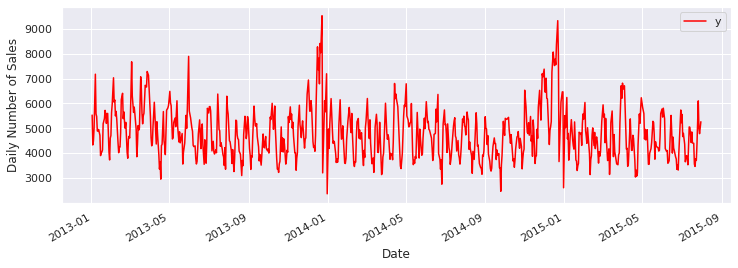

In [50]:

sales = preprocess_(df_train)

In [51]:
holidays = modeling_holiday(df_train)

In [52]:
prophet = Fb_prophet(sales,holidays)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [53]:
week=3 #no of weeks we want to forcast
fd = prophet.getFuture_dates(week)
predict =prophet.get_predicate()


<AxesSubplot:xlabel='Date', ylabel='Forecast_Sales'>

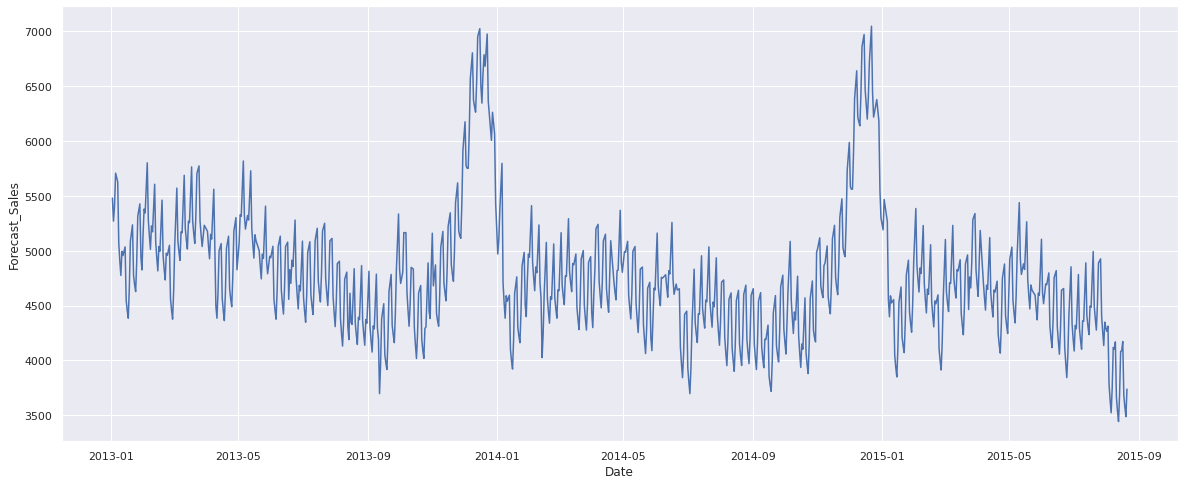

In [54]:
sns.lineplot(x=predict['Date'],y=predict['Forecast_Sales'],data=predict)

In [55]:
prophet.get_performanceMetrics()

<AxesSubplot:xlabel='Date', ylabel='Forecast_Sales'>

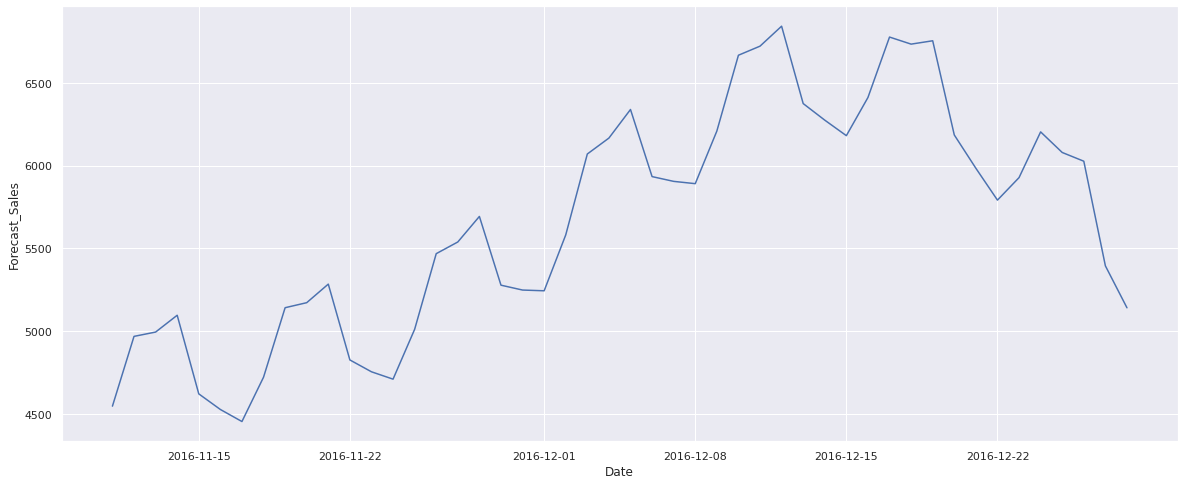

In [56]:
data_f = pd.DataFrame()
start_date= '2016-11-11'
end_date= '2016-12-25'
data_f['ds'] = pd.date_range(start_date, periods = 48, freq ='D') 

p = prophet.model.predict(data_f)
fc = p[['ds', 'yhat']].rename(columns = {'ds': 'Date', 'yhat': 'Forecast_Sales'})
sns.lineplot(x=fc['Date'],y=fc['Forecast_Sales'],data=fc)

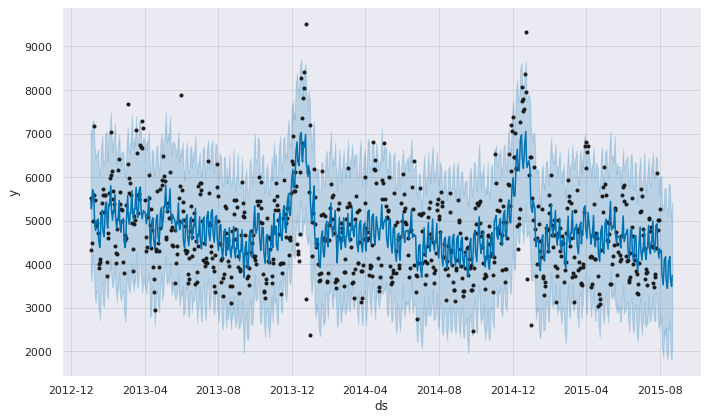

In [57]:
prophet.eff_modlel()
filename = prophet.save_model()